In [1]:
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense

In [2]:
# Assume we have some time series data
data = np.random.rand(1000)  # Replace this with your actual data

# Preprocess the data to create input/output pairs
input_data = []
output_data = []
for i in range(len(data) - 37):
    input_data.append(data[i:i+30])
    output_data.append(data[i+30:i+37])
input_data = np.array(input_data)
output_data = np.array(output_data)

# Reshape data for LSTM
input_data = np.reshape(input_data, (input_data.shape[0], input_data.shape[1], 1))
output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[1], 1))

# Define the encoder
encoder_inputs = Input(shape=(None, 1))
encoder = LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Define the decoder
decoder_inputs = Input(shape=(None, 1))
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(1)
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit([input_data[:-7], output_data[:-7]], output_data[:-7], batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
24/24 [==============================] - 6s 52ms/step - loss: 0.1462 - val_loss: 0.0852
Epoch 2/10
24/24 [==============================] - 0s 16ms/step - loss: 0.0746 - val_loss: 0.0741
Epoch 3/10
24/24 [==============================] - 0s 15ms/step - loss: 0.0692 - val_loss: 0.0687
Epoch 4/10
24/24 [==============================] - 0s 16ms/step - loss: 0.0639 - val_loss: 0.0620
Epoch 5/10
24/24 [==============================] - 0s 15ms/step - loss: 0.0570 - val_loss: 0.0527
Epoch 6/10
24/24 [==============================] - 0s 16ms/step - loss: 0.0458 - val_loss: 0.0374
Epoch 7/10
24/24 [==============================] - 0s 15ms/step - loss: 0.0290 - val_loss: 0.0188
Epoch 8/10
24/24 [==============================] - 0s 15ms/step - loss: 0.0110 - val_loss: 0.0046
Epoch 9/10
24/24 [==============================] - 0s 15ms/step - loss: 0.0020 - val_loss: 5.2652e-04
Epoch 10/10
24/24 [==============================] - 0s 16ms/step - loss: 2.4165e-04 - val_loss: 9.7799e-

1/1 [==============================] - 0s 51ms/step


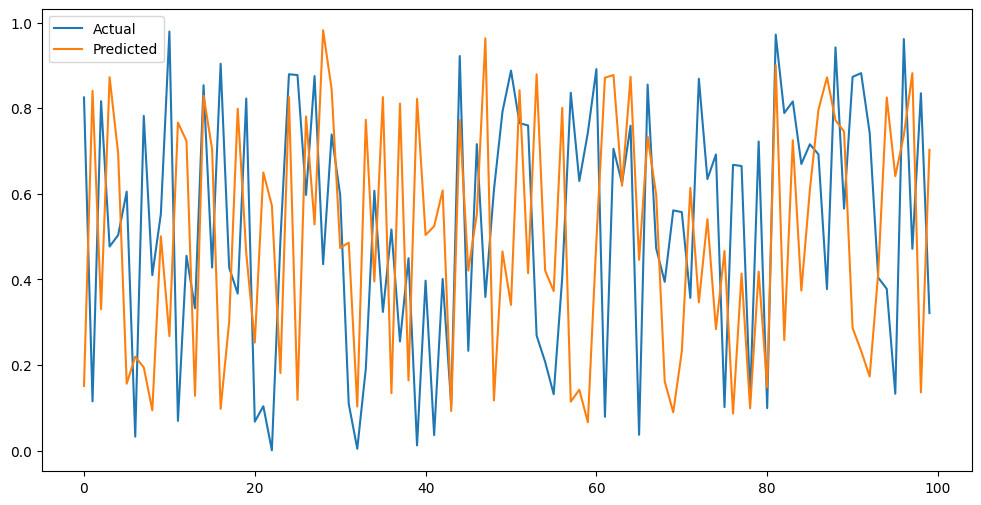

In [3]:
import matplotlib.pyplot as plt

# Define the encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# Define the decoder model
decoder_state_input_h = Input(shape=(50,))
decoder_state_input_c = Input(shape=(50,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Function to generate predictions
def predict(input_seq):
    # Encode the input sequence to get the internal state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1 with only the start character.
    target_seq = np.zeros((1, 1, 1))
    target_seq[0, 0, 0] = input_seq[0, 0, 0]  # Use first input as start for prediction
    
    # Sampling loop for a batch of sequences
    decoded_seq = np.zeros((1,7,1))
    for i in range(7):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token and add predicted token to the decoded sequence
        decoded_seq[0,i,0] = output_tokens[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output_tokens[0,0,0]

        # Update states
        states_value = [h, c]
        
    return decoded_seq

# Generate some predictions
predictions = []
for seq_index in range(100):
    input_seq = input_data[seq_index: seq_index + 1]
    decoded_sentence = predict(input_seq)
    predictions.append(decoded_sentence[0,-1,0])  # Append the last predicted value

# Plot the predictions vs actual data
plt.figure(figsize=(12, 6))
plt.plot(data[37:137], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()